In [1]:
import os
import tensorflow as tf
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

2022-12-12 11:25:58.850638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 11:25:59.301221: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-12 11:25:59.301249: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-12 11:26:00.874192: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

In [2]:
train_dir = '../dataset_reducida/train'
validation_dir = '../dataset_reducida/validation'

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=39,
                                   width_shift_range=0.33,
                                   height_shift_range=0.24,
                                   zoom_range=0.36,
                                   shear_range=0.27,
                                   horizontal_flip=True,
                                   fill_mode='nearest')  # with data augmentation for train set

valid_datagen = ImageDataGenerator(rescale=1./255)  # no augmentation for validation set

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=45,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))


validation_generator = valid_datagen.flow_from_directory(validation_dir,
                                                         batch_size=45,
                                                         class_mode='categorical',
                                                         target_size=(224, 224))


Found 1847 images belonging to 3 classes.
Found 452 images belonging to 3 classes.


In [3]:
pasos_entrenamiento = train_generator.n//train_generator.batch_size
pasos_validacion = validation_generator.n//validation_generator.batch_size

In [4]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > 0.99 and logs.get('val_acc') > 0.99):
            print("\nCancelling training as model has reached 99% accuracy and 99% validation accuracy!")
            self.model.stop_training = True


In [5]:
def plot_result(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()
    plt.savefig("plot.png")


In [6]:
# Download Inception v3 weights to local machine
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Import Inception v3 Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
pre_trained_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights=None)

# Load Inception v3 weights into model
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model.load_weights(local_weights_file)

--2022-12-12 11:26:03--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving storage.googleapis.com (storage.googleapis.com)... 2800:3f0:4003:c02::80, 2800:3f0:4003:c01::80, 2800:3f0:4003:c00::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2800:3f0:4003:c02::80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83,84M  26,7MB/s    in 3,4s    

2022-12-12 11:26:12 (24,9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



2022-12-12 11:26:12.564917: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-12 11:26:12.564955: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-12 11:26:12.564987: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cipherStark): /proc/driver/nvidia/version does not exist
2022-12-12 11:26:12.565674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [8]:
pre_trained_model.summary()
plot_model(pre_trained_model, to_file='inception_v3_model.png', show_shapes=False, show_layer_names=True)


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [9]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [10]:
img_width, img_height = 224, 224

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

inputs = layers.Input(shape=input_shape)


x = layers.Flatten()(last_output)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.412345)(x)
x = layers.Dense(2048, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)

x = layers.Dense(3, activation='softmax')(x)

model = Model(pre_trained_model.input, x)


In [11]:
model.summary()
plot_model(model, to_file='inception_v3_with_dense_layers_model.png', show_shapes=False, show_layer_names=True)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
model.compile(loss='categorical_crossentropy',
           optimizer=optimizers.Adam(lr=0.0006),
           metrics=['accuracy'])
H = model.fit_generator(
    train_generator,
    steps_per_epoch=pasos_entrenamiento,
    epochs = 27,
    validation_data = validation_generator,
    validation_steps= pasos_validacion)

/home/j3st3j/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_101335/3983170972.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/27
41/41 [==============================] - 216s 5s/step - loss: 2.9382 - accuracy: 0.4839 - val_loss: 0.6363 - val_accuracy: 0.7289
Epoch 2/27
41/41 [==============================] - 214s 5s/step - loss: 0.6947 - accuracy: 0.6815 - val_loss: 0.7906 - val_accuracy: 0.6600
Epoch 3/27
41/41 [==============================] - 192s 5s/step - loss: 0.6825 - accuracy: 0.7120 - val_loss: 0.5502 - val_accuracy: 0.7467
Epoch 4/27
41/41 [==============================] - 139s 3s/step - loss: 0.5886 - accuracy: 0.7392 - val_loss: 0.5100 - val_accuracy: 0.7733
Epoch 5/27
41/41 [==============================] - 139s 3s/step - loss: 0.6116 - accuracy: 0.7431 - val_loss: 0.4953 - val_accuracy: 0.7689
Epoch 6/27
41/41 [==============================] - 138s 3s/step - loss: 0.6067 - accuracy: 0.7392 - val_loss: 0.4530 - val_accuracy: 0.7933
Epoch 7/27
41/41 [==============================] - 136s 3s/step - loss: 0.5581 - accuracy: 0.7614 - val_loss: 0.4610 - val_accuracy: 0.7800
Epoch 8/27
41

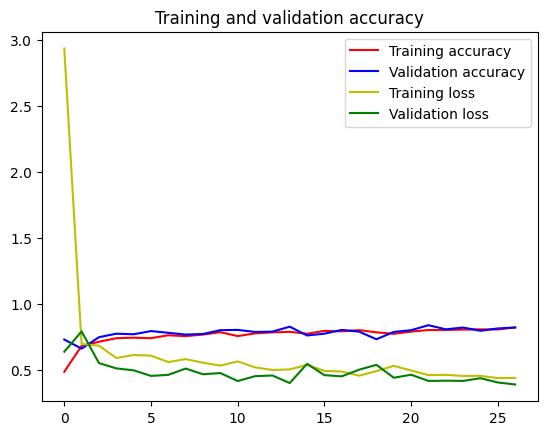

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [13]:
plot_result(H)
#N=27
#6model.save('model215epochs.h5')

 

In [14]:
#a= tf.keras.models.load_model('./model_al_86.h5')
#a.summary()


In [15]:
model.compile(loss='categorical_crossentropy',
           optimizer=optimizers.Adam(lr=0.0006),
           metrics=['accuracy'])
H = model.fit_generator(
    train_generator,
    steps_per_epoch=pasos_entrenamiento,
    epochs = 18,
    validation_data = validation_generator,
    validation_steps= pasos_validacion)

/tmp/ipykernel_101335/3436252454.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/18
41/41 [==============================] - 149s 4s/step - loss: 0.5121 - accuracy: 0.7958 - val_loss: 0.4233 - val_accuracy: 0.8200
Epoch 2/18
41/41 [==============================] - 139s 3s/step - loss: 0.4583 - accuracy: 0.8091 - val_loss: 0.4461 - val_accuracy: 0.8200
Epoch 3/18
41/41 [==============================] - 146s 4s/step - loss: 0.4592 - accuracy: 0.8174 - val_loss: 0.4180 - val_accuracy: 0.8089
Epoch 4/18
41/41 [==============================] - 135s 3s/step - loss: 0.4578 - accuracy: 0.8130 - val_loss: 0.4627 - val_accuracy: 0.7889
Epoch 5/18
41/41 [==============================] - 137s 3s/step - loss: 0.4804 - accuracy: 0.7897 - val_loss: 0.3976 - val_accuracy: 0.8378
Epoch 6/18
41/41 [==============================] - 139s 3s/step - loss: 0.4538 - accuracy: 0.8141 - val_loss: 0.4505 - val_accuracy: 0.7933
Epoch 7/18
41/41 [==============================] - 138s 3s/step - loss: 0.4554 - accuracy: 0.8074 - val_loss: 0.4515 - val_accuracy: 0.8022
Epoch 8/18
41

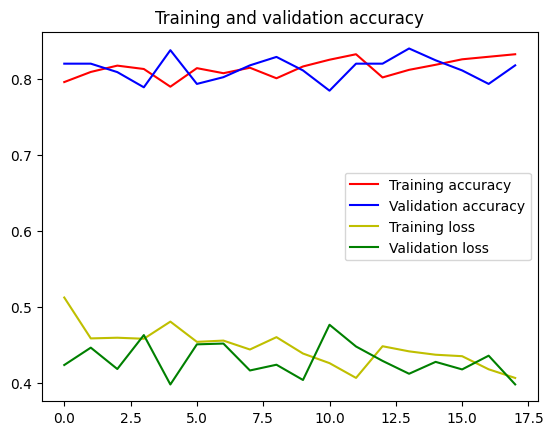

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
plot_result(H)

In [17]:
model.compile(loss='categorical_crossentropy',
           optimizer=optimizers.Adam(lr=0.0006),
           metrics=['accuracy'])
H = model.fit_generator(
    train_generator,
    steps_per_epoch=pasos_entrenamiento,
    epochs = 9,
    validation_data = validation_generator,
    validation_steps= pasos_validacion)

/tmp/ipykernel_101335/1264158775.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/9
41/41 [==============================] - 138s 3s/step - loss: 0.4777 - accuracy: 0.8063 - val_loss: 0.4468 - val_accuracy: 0.8178
Epoch 2/9
41/41 [==============================] - 137s 3s/step - loss: 0.4099 - accuracy: 0.8280 - val_loss: 0.5208 - val_accuracy: 0.7978
Epoch 3/9
41/41 [==============================] - 137s 3s/step - loss: 0.4404 - accuracy: 0.8202 - val_loss: 0.5047 - val_accuracy: 0.8022
Epoch 4/9
41/41 [==============================] - 140s 3s/step - loss: 0.4244 - accuracy: 0.8298 - val_loss: 0.4459 - val_accuracy: 0.7978
Epoch 5/9
41/41 [==============================] - 148s 4s/step - loss: 0.4082 - accuracy: 0.8430 - val_loss: 0.4207 - val_accuracy: 0.8244
Epoch 6/9
41/41 [==============================] - 147s 4s/step - loss: 0.4249 - accuracy: 0.8280 - val_loss: 0.4763 - val_accuracy: 0.8000
Epoch 7/9
41/41 [==============================] - 147s 4s/step - loss: 0.4349 - accuracy: 0.8119 - val_loss: 0.4432 - val_accuracy: 0.8333
Epoch 8/9
41/41 [===

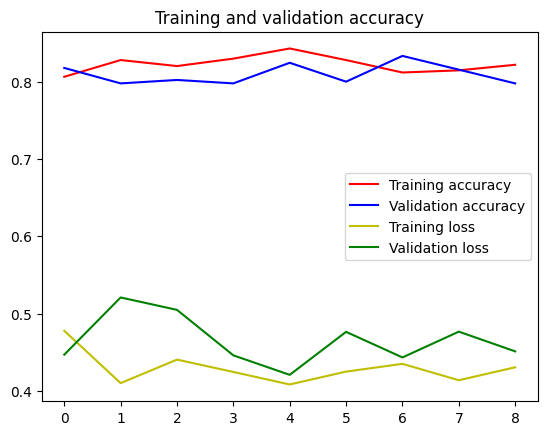

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [18]:
plot_result(H)

In [19]:
model.compile(loss='categorical_crossentropy',
           optimizer=optimizers.Adam(lr=0.0006),
           metrics=['accuracy'])
H = model.fit_generator(
    train_generator,
    steps_per_epoch=pasos_entrenamiento,
    epochs = 12,
    validation_data = validation_generator,
    validation_steps= pasos_validacion)

/tmp/ipykernel_101335/2107951105.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/12
41/41 [==============================] - 217s 5s/step - loss: 0.4159 - accuracy: 0.8263 - val_loss: 0.4031 - val_accuracy: 0.8244
Epoch 2/12
41/41 [==============================] - 212s 5s/step - loss: 0.4041 - accuracy: 0.8357 - val_loss: 0.4079 - val_accuracy: 0.8222
Epoch 3/12
41/41 [==============================] - 205s 5s/step - loss: 0.3795 - accuracy: 0.8424 - val_loss: 0.4386 - val_accuracy: 0.8289
Epoch 4/12
41/41 [==============================] - 210s 5s/step - loss: 0.3969 - accuracy: 0.8396 - val_loss: 0.4691 - val_accuracy: 0.8111
Epoch 5/12
41/41 [==============================] - 206s 5s/step - loss: 0.4074 - accuracy: 0.8280 - val_loss: 0.4278 - val_accuracy: 0.8244
Epoch 6/12
41/41 [==============================] - 201s 5s/step - loss: 0.3734 - accuracy: 0.8529 - val_loss: 0.4238 - val_accuracy: 0.8356
Epoch 7/12
41/41 [==============================] - 206s 5s/step - loss: 0.3692 - accuracy: 0.8463 - val_loss: 0.4417 - val_accuracy: 0.8244
Epoch 8/12
41

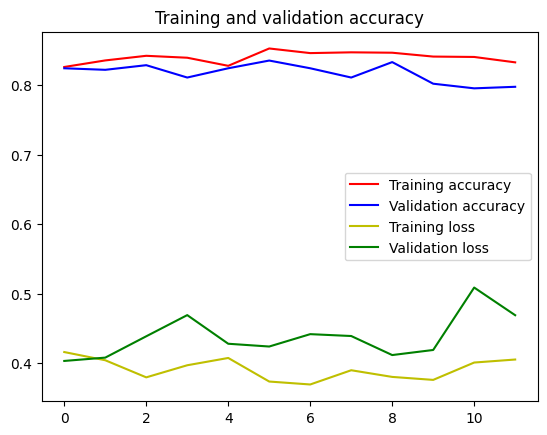

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
plot_result(H)

In [21]:
model.compile(loss='categorical_crossentropy',
           optimizer=optimizers.Adam(lr=0.00003),
           metrics=['accuracy'])
H = model.fit_generator(
    train_generator,
    steps_per_epoch=pasos_entrenamiento,
    epochs = 18,
    validation_data = validation_generator,
    validation_steps= pasos_validacion)

/home/j3st3j/.local/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/tmp/ipykernel_101335/4080885392.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/18
41/41 [==============================] - 204s 5s/step - loss: 0.4262 - accuracy: 0.8158 - val_loss: 0.4375 - val_accuracy: 0.8044
Epoch 2/18
41/41 [==============================] - 193s 5s/step - loss: 0.3904 - accuracy: 0.8313 - val_loss: 0.4300 - val_accuracy: 0.8044
Epoch 3/18
41/41 [==============================] - 194s 5s/step - loss: 0.3737 - accuracy: 0.8474 - val_loss: 0.4276 - val_accuracy: 0.8022
Epoch 4/18
41/41 [==============================] - 203s 5s/step - loss: 0.3654 - accuracy: 0.8468 - val_loss: 0.4228 - val_accuracy: 0.8133
Epoch 5/18
41/41 [==============================] - 205s 5s/step - loss: 0.3514 - accuracy: 0.8435 - val_loss: 0.4202 - val_accuracy: 0.8178
Epoch 6/18
41/41 [==============================] - 204s 5s/step - loss: 0.3336 - accuracy: 0.8629 - val_loss: 0.4140 - val_accuracy: 0.8222
Epoch 7/18
41/41 [==============================] - 199s 5s/step - loss: 0.3383 - accuracy: 0.8679 - val_loss: 0.4278 - val_accuracy: 0.8133
Epoch 8/18
41

In [ ]:
model.save('model_al86_82.h5')